---
title: "MNIST Classification on Raspberry Pi pico"
author: "Nils Poethkow"
---

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

mnist = tf.keras.datasets.mnist
(x_train, y_train) , (x_test, y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0

In [27]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

Get models and further enhance them for the use on Raspberry Pi Pico. 

Quantization the model so it works with values from 1 to 255. It reduces the memory usage and exallerates the inference <br> Post training quantization.

## Convert Trained Tensorflow models into Tensorflow LiteRT format

**Workflow**:
1. Load trained model from a ".keras" file
2. Convert it with Quantization to a Tensorflow LiteRT model and save it in a ".tflite" file
3. Convert ".tflite" to c-type array using this command: "xxd -i model.tflite > model_data.cc"
4. Copy Data into "mnist_model_data.cpp" file
5. Adjust Operations in "model.cpp" file

### Feed Forward Neural Networks (fully connected)

First, we convert the initial model in to a TensorFlow lite model and save it in a ".tflite" file, to compare it to the optimized models later.

In [ ]:
initial_model = load_model("../HW2/models/initial_model.keras") # put model somewhere else

# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(initial_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    random_indices = np.random.choice(x_train.shape[0], 1000, replace=False)
    
    for i in range(1000):  # Use 100 samples for quantization
        # Yield one sample at a time, reshaped to match the model input shape
        yield [x_train[i].astype("float32").reshape(1, 28, 28)]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # Input type set to uint8
converter.inference_output_type = tf.uint8  # Output type set to uint8

tflite_model = converter.convert()

# Save in .tflite file
with open('models/initial_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpnatsp3bu/assets


INFO:tensorflow:Assets written to: /tmp/tmpnatsp3bu/assets


Saved artifact at '/tmp/tmpnatsp3bu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140558996291280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140560648174080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558586687760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140560597112560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558587736336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559523631824: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/nils03/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733575601.607336    7781 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733575601.608031    7781 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-07 14:46:41.609746: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpnatsp3bu
2024-12-07 14:46:41.610652: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-07 14:46:41.610669: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpnatsp3bu
2024-12-07 14:46:41.617032: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-07 14:46:41.652618: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpnats

Predictions with this model where very unstable with probabilities very evenly distributed over the digits. A more in depth investigation of this is provided in the paper.

In the Initial Model used above, the Output Layer didn't use the Softmax activation function, therefore probabilities didn't add up to 100%. This issue was fixed in the next test for the initial model, let's see if the performance is more stable now.

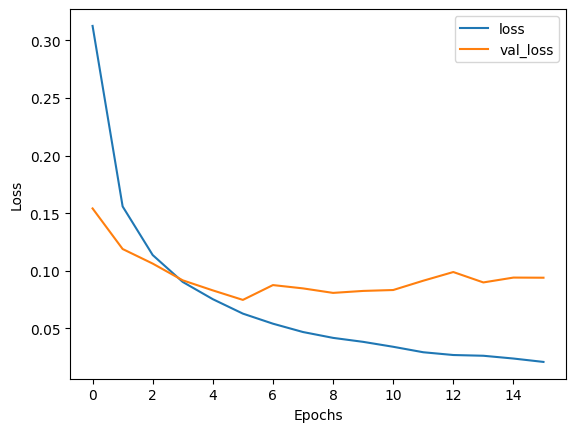

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9933 - loss: 0.0209 - val_accuracy: 0.9785 - val_loss: 0.0940
INFO:tensorflow:Assets written to: /tmp/tmpmgmbg0tf/assets


INFO:tensorflow:Assets written to: /tmp/tmpmgmbg0tf/assets


Saved artifact at '/tmp/tmpmgmbg0tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor_1074')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140558587610208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558643138752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558643144032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558643142096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558643150368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558643200240: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/nils03/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733578100.786407    7781 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733578100.786821    7781 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-07 15:28:20.787264: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmgmbg0tf
2024-12-07 15:28:20.787915: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-07 15:28:20.787928: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpmgmbg0tf
2024-12-07 15:28:20.794749: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-07 15:28:20.834255: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpmgmb

In [51]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout

new_initial_model = Sequential()
new_initial_model.add(Flatten(input_shape=(28, 28)))
new_initial_model.add(Dense(80, activation='elu'))
new_initial_model.add(Dense(60, activation='elu'))
new_initial_model.add(Dropout(0.2))
new_initial_model.add(Dense(10, activation='softmax'))    # no softmax, MISTAKE

#### Trainiing ####
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

new_initial_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
new_initial_model.fit(x_train, y_train, epochs=50,
          callbacks = [plot_losses, EarlyStopping],
          validation_data = [x_test, y_test],)


#### Converting ####
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(new_initial_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    random_indices = np.random.choice(x_train.shape[0], 1000, replace=False)
    
    for i in range(1000):  # Use 100 samples for quantization
        # Yield one sample at a time, reshaped to match the model input shape
        yield [x_train[i].astype("float32").reshape(1, 28, 28)]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # Input type set to uint8
converter.inference_output_type = tf.uint8  # Output type set to uint8

tflite_model = converter.convert()

# Save in .tflite file
with open('models/new_initial_model.tflite', 'wb') as f:
    f.write(tflite_model)

Results for this model were slightly more stable, however, overall performance was still very poor with still evenly distributed probabilities over the digits. Therefore, this model shows poor generalization behavior or custom handwritten digits.

Let's see if a Feed Forward Neural Network with optimized Architecture performs better. For this we also have a already trained model.

In [ ]:
optimized_architecture_model = load_model("../HW2/models/initial_model.keras") # put model somewhere else

# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(optimized_architecture_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    random_indices = np.random.choice(x_train.shape[0], 1000, replace=False)
    
    for i in range(1000):  # Use 100 samples for quantization
        # Yield one sample at a time, reshaped to match the model input shape
        yield [x_train[i].astype("float32").reshape(1, 28, 28)]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # Input type set to uint8
converter.inference_output_type = tf.uint8  # Output type set to uint8

tflite_model = converter.convert()

# Save in .tflite file
with open('models/optimized_architecture_model.tflite', 'wb') as f:
    f.write(tflite_model)

### Convolutional Neural Networks (CNNs)

In [ ]:
# Use mobile net from Home Assignment since the performance
mobile_net_model = load_model("../HW2/models/mobile_net.keras") # put model somewhere else

# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(mobile_net_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    random_indices = np.random.choice(x_train.shape[0], 1000, replace=False)
    
    for i in range(1000):  # Use 100 samples for quantization
        # Yield one sample at a time, reshaped to match the model input shape
        yield [x_train[i].astype("float32").reshape(-1, 28, 28, 1)]  # -1 -> find shape yourself

# Convert the model to TensorFlow Lite format with quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float32]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # Input type set to uint8
converter.inference_output_type = tf.uint8  # Output type set to uint8

tflite_mobile_net = converter.convert()

# Save in .tflite file
with open('mobile_net.tflite', 'wb') as f:
    f.write(tflite_mobile_net)

INFO:tensorflow:Assets written to: /tmp/tmptubehsk_/assets


INFO:tensorflow:Assets written to: /tmp/tmptubehsk_/assets


Saved artifact at '/tmp/tmptubehsk_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_6')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140559008147136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559008151712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559010165008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559010158496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559008140096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559010163776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559010165888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559010163424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559010153040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559010161136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14055901016852

/home/nils03/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733489651.767591    7781 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733489651.767648    7781 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-06 14:54:11.767870: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmptubehsk_
2024-12-06 14:54:11.772464: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-06 14:54:11.772504: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmptubehsk_
2024-12-06 14:54:11.822440: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-06 14:54:12.172064: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmptube

The performance of the mobile net is significantly better on the handwritten digits, thus generalizing better than the initial feed forward network.

Let's also try the squeeze net which is more memory efficient, but also showed a worse performance in the last Home Assignment on the custom handwritten digits.

In [ ]:
# Use squeeze net from Home Assignment 2
squeeze_net_model = load_model("../HW2/models/squeeze_net.keras")

# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(squeeze_net_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    random_indices = np.random.choice(x_train.shape[0], 1000, replace=False)
    
    for i in range(1000):  # Use 100 samples for quantization
        # Yield one sample at a time, reshaped to match the model input shape
        yield [x_train[i].astype("float32").reshape(-1, 28, 28, 1)]  # -1 -> find shape yourself

# Convert the model to TensorFlow Lite format with quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float32]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # Input type set to uint8
converter.inference_output_type = tf.uint8  # Output type set to uint8

tflite_mobile_net = converter.convert()

# Save in .tflite file
with open('models/squeeze_net.tflite', 'wb') as f:
    f.write(tflite_mobile_net)

INFO:tensorflow:Assets written to: /tmp/tmp6ys8ya9c/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ys8ya9c/assets


Saved artifact at '/tmp/tmp6ys8ya9c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140558993302176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993297248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993304816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993360672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993366304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993363664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993369296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993369472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993373520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558993374224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14055899337440

/home/nils03/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733501584.760591    7781 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733501584.763820    7781 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-06 18:13:04.770351: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6ys8ya9c
2024-12-06 18:13:04.772824: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-06 18:13:04.772857: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp6ys8ya9c
2024-12-06 18:13:04.807415: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-06 18:13:05.056076: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp6ys8

**Compare** the size of the mobile net with quantization and without.

### New Architecture

Let's also try the LeNet-5, proposed in the lecture. First we need build and train the model.

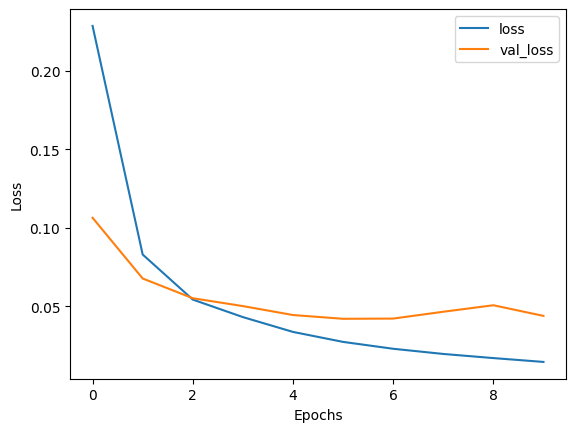

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9964 - loss: 0.0129 - val_accuracy: 0.9867 - val_loss: 0.0440
313/313 - 1s - 3ms/step - accuracy: 0.9867 - loss: 0.0440


[0.04396679252386093, 0.9866999983787537]

In [ ]:
from lenet_functions import create_lenet

lenet_model = create_lenet()

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lenet_model.compile(optimizer= 'adam', loss=loss_fn, metrics= ['accuracy'])

lenet_model.summary()

history_lenet_model = lenet_model.fit(x_train, y_train, 
                                      epochs=10, # With an epoch number of greater than 10, the model already starts to overfit.
                                      validation_data=[x_test, y_test], 
                                      callbacks=[plot_losses])

lenet_model.evaluate(x_test, y_test, verbose=2)


The Accuracy of the Lenet-5 Network on the test set is about the same as the mobile and squeeze net, which are also CNNs.

In [54]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

from HW2.functions import determine_model_size, measure_inference_time

model_inference_time = measure_inference_time(model, x_test)
print(f"Inference Time Lenet-5: {model_inference_time} s")

lenet_model.save("models/lenet.keras")

model_size = determine_model_size("models/lenet.keras")

print(f"Model Size Lenet-5: {model_size} MB")


Inference Time Lenet-5: 0.6013665080070496 s
Model Size Lenet-5: 0.7513465881347656 MB


Compared to the mobile and squeeze net however, the lenet-5 net shows a significantly faster inference speed, since the proposed network is also significantly less complex while preserving the accuracy.

Now we convert the model with Tensorflow LiteRT.

In [35]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(lenet_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    mnist = tf.keras.datasets.mnist

    random_indices = np.random.choice(x_train.shape[0], 1000, replace=False)
    
    for i in range(1000):  # Use 100 samples for quantization
        # Yield one sample at a time, reshaped to match the model input shape
        yield [x_train[i].astype("float32").reshape(-1, 28, 28, 1)]  # -1 -> find shape yourself

# Convert the model to TensorFlow Lite format with quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float32]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # Input type set to uint8
converter.inference_output_type = tf.uint8  # Output type set to uint8

tflite_mobile_net = converter.convert()

# Save in .tflite file
with open('models/lenet.tflite', 'wb') as f:
    f.write(tflite_mobile_net)

INFO:tensorflow:Assets written to: /tmp/tmpajfbyu0y/assets


INFO:tensorflow:Assets written to: /tmp/tmpajfbyu0y/assets


Saved artifact at '/tmp/tmpajfbyu0y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_955')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140558996287936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600237152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600411392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600409456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600406112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600536480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600540176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600541584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600544400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600545808: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/nils03/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733573049.393298    7781 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733573049.393517    7781 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-07 14:04:09.393983: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpajfbyu0y
2024-12-07 14:04:09.395108: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-07 14:04:09.395130: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpajfbyu0y
2024-12-07 14:04:09.406383: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-07 14:04:09.457583: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpajfb

Let's also try the **Optimized Architecture** model from the previous Home Assignment. It's uncertain whether this model will work without any further optimization, because the model size is 6.5 MB.

In [55]:
# test model
optimized_architecture_model = load_model("../HW2/models/optimized_architecture.keras") # put model somewhere else

# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(optimized_architecture_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_data_gen():
    random_indices = np.random.choice(x_train.shape[0], 1000, replace=False)
    
    for i in range(1000):  # Use 100 samples for quantization
        # Yield one sample at a time, reshaped to match the model input shape
        yield [x_train[i].astype("float32").reshape(1, 28, 28)]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # Input type set to uint8
converter.inference_output_type = tf.uint8  # Output type set to uint8

tflite_model = converter.convert()

# Save in .tflite file
with open('models/optimized_architecture_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdu92cxd9/assets


INFO:tensorflow:Assets written to: /tmp/tmpdu92cxd9/assets


Saved artifact at '/tmp/tmpdu92cxd9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_8')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  140559011333568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558600686400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559523711984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558989543728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559522534448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558989542672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140558989544784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140559004077920: TensorSpec(shape=(), dtype=tf.resource, name=None)


/home/nils03/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1733584147.929278    7781 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733584147.932242    7781 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-07 17:09:07.939315: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdu92cxd9
2024-12-07 17:09:07.941784: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-07 17:09:07.941799: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpdu92cxd9
2024-12-07 17:09:07.960009: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-07 17:09:08.068082: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpdu92

### Compare all models 

In [74]:
import pandas as pd

model_performances = pd.read_csv("model_performance.csv", sep=",")

display(model_performances)

,initial_model,optimized_architecture,mobile_net,squeeze_net,lenet
0,0,4,6,5,5
1,2,2,6,6,6
2,0,3,6,6,5
3,0,5,6,6,6
4,2,5,6,5,5
5,3,4,5,6,6
6,4,1,6,5,6
7,3,6,6,6,5
8,0,6,6,6,6
9,0,4,5,6,6


Now the accuracies for every digit for every model and the overall accuracies are calculated.

In [82]:
def calc_overall_accuracy(model_performances):

    accuracy_per_digit = pd.DataFrame()
    overall_accuracies = {}

    for model in model_performances.columns:
        accuracy_per_digit[model] = model_performances[model] / 6
        overall_accuracies[model] = model_performances[model].sum() / 60
    
    accuracy_per_digit.loc["Overall Accuracy"] = overall_accuracies

    return accuracy_per_digit

accuracies = calc_overall_accuracy(model_performances)
display(accuracies)

,initial_model,optimized_architecture,mobile_net,squeeze_net,lenet
0,0.000000,0.666667,1.000000,0.833333,0.833333
1,0.333333,0.333333,1.000000,1.000000,1.000000
2,0.000000,0.500000,1.000000,1.000000,0.833333
3,0.000000,0.833333,1.000000,1.000000,1.000000
4,0.333333,0.833333,1.000000,0.833333,0.833333
5,0.500000,0.666667,0.833333,1.000000,1.000000
6,0.666667,0.166667,1.000000,0.833333,1.000000
7,0.500000,1.000000,1.000000,1.000000,0.833333
8,0.000000,1.000000,1.000000,1.000000,1.000000
9,0.000000,0.666667,0.833333,1.000000,1.000000
